# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, col, udf, desc, max as Fmax, lag, struct, date_add, sum as Fsum
from pyspark.sql.functions import datediff, date_trunc, row_number, when, coalesce, avg as Favg
from pyspark.sql.types import IntegerType, DateType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

In [2]:
# Creating a Spark Session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
## 10/18 Note to self: delete local json file and read.json line and uncomment below two lines for AWS
# event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# df = spark.read.json(event_data)
df = spark.read.json('mini_sparkify_event_data.json')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [4]:
def shape_ps_df(df):
    '''
    Print shape of PySpark DataFrame
    '''
    print(f'DF Shape: ({df.count()},{len(df.columns)})')

In [5]:
shape_ps_df(df)

DF Shape: (286500,18)


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

Taking a look at the contents of a few columns...

In [8]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [10]:
df.groupBy('page').agg(count(col('userId')).alias('count_visits')).show(25)

+--------------------+------------+
|                page|count_visits|
+--------------------+------------+
|              Cancel|          52|
|    Submit Downgrade|          63|
|         Thumbs Down|        2546|
|                Home|       14457|
|           Downgrade|        2055|
|         Roll Advert|        3933|
|              Logout|        3226|
|       Save Settings|         310|
|Cancellation Conf...|          52|
|               About|         924|
| Submit Registration|           5|
|            Settings|        1514|
|               Login|        3241|
|            Register|          18|
|     Add to Playlist|        6526|
|          Add Friend|        4277|
|            NextSong|      228108|
|           Thumbs Up|       12551|
|                Help|        1726|
|             Upgrade|         499|
|               Error|         258|
|      Submit Upgrade|         159|
+--------------------+------------+



Seems like `Cancellation Confirmation` and `Downgrade` are good indicators of churn.

In [11]:
# Taking a look at the userIds
df.select('userId').sort('userId').dropDuplicates().show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [12]:
# Dropping the blank userIds
df = df.where(col('userId')!='')

### Exploring Location Data

In [13]:
# Taking a look at location
df.select('location').sort('location').dropDuplicates().take(10)

[Row(location='Albany, OR'),
 Row(location='Albany-Schenectady-Troy, NY'),
 Row(location='Alexandria, LA'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Anchorage, AK'),
 Row(location='Atlanta-Sandy Springs-Roswell, GA'),
 Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Austin-Round Rock, TX'),
 Row(location='Bakersfield, CA'),
 Row(location='Baltimore-Columbia-Towson, MD')]

In [14]:
# Location roughly looks like we may be able to parse the state by taking the last two character strings
get_state = udf(lambda x: x[-2:])
df = df.withColumn('state',get_state(col('location')))

In [15]:
df.select('state').dropDuplicates().count()

39

In [16]:
# Listens by state
df.filter(col('page')=='NextSong') \
    .groupBy('state') \
    .agg(count('userId').alias('count')) \
    .sort(desc('count')) \
    .show(40)

+-----+-----+
|state|count|
+-----+-----+
|   CA|38271|
|   PA|21722|
|   TX|19296|
|   NH|15422|
|   FL|10729|
|   NC| 9553|
|   MD| 7053|
|   WI| 7041|
|   SC| 6979|
|   IN| 6737|
|   NJ| 6521|
|   CO| 6198|
|   MI| 5914|
|   IL| 5631|
|   CT| 5545|
|   VA| 5449|
|   WV| 5157|
|   AL| 4573|
|   AZ| 3956|
|   MS| 3909|
|   NY| 3704|
|   GA| 3479|
|   WA| 3183|
|   AK| 2963|
|   KY| 2892|
|   OH| 2804|
|   KS| 2134|
|   MT| 1995|
|   NV| 1679|
|   OK| 1571|
|   TN| 1393|
|   UT|  929|
|   LA|  888|
|   MO|  767|
|   MA|  710|
|   IA|  649|
|   AR|  464|
|   ID|  237|
|   OR|   11|
+-----+-----+



In [17]:
# Unique users
df.select(['userId']).dropDuplicates().count()

225

In [18]:
# Unique users by state
df.filter(col('page')=='NextSong') \
    .dropDuplicates(['userId']) \
    .groupBy('state') \
    .agg(count('userId').alias('count')) \
    .sort(desc('count')) \
    .show(40)

+-----+-----+
|state|count|
+-----+-----+
|   CA|   33|
|   PA|   18|
|   TX|   16|
|   FL|   14|
|   WI|   10|
|   NC|    9|
|   IL|    9|
|   SC|    8|
|   AZ|    7|
|   CT|    7|
|   NH|    7|
|   MD|    7|
|   WA|    6|
|   IN|    6|
|   AL|    6|
|   WV|    6|
|   MI|    5|
|   NY|    5|
|   CO|    4|
|   GA|    4|
|   MS|    3|
|   OH|    3|
|   KY|    3|
|   NJ|    3|
|   NV|    3|
|   VA|    3|
|   MT|    2|
|   KS|    2|
|   IA|    2|
|   LA|    2|
|   AK|    2|
|   MA|    2|
|   AR|    2|
|   OR|    1|
|   MO|    1|
|   ID|    1|
|   OK|    1|
|   TN|    1|
|   UT|    1|
+-----+-----+



Looks like most of Sparkify's listeners live in California, and we don't have all 50 states represented.

### Exploring Date Data
Now feature engineering more granularity from the timestamp column.

In [19]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour,IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day,IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month,IntegerType())
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).year,IntegerType())

In [20]:
df = df \
    .withColumn('hour',get_hour(col('ts'))) \
    .withColumn('day',get_day(col('ts'))) \
    .withColumn('month',get_month(col('ts'))) \
    .withColumn('year',get_year(col('ts')))

In [21]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018)]

In [22]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000),DateType())
df = df.withColumn('date',get_date(col('ts')))
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018, date=datetime.date(2018, 10, 1))]

Now aggregating by date data to see if there are any trends.

In [23]:
df.filter(col('page')=='NextSong').groupBy('hour').agg(count('userId')).sort('hour').show(25)

+----+-------------+
|hour|count(userId)|
+----+-------------+
|   0|         9062|
|   1|         8388|
|   2|         8336|
|   3|         8355|
|   4|         8147|
|   5|         8178|
|   6|         8054|
|   7|         8091|
|   8|         8253|
|   9|         8498|
|  10|         8882|
|  11|         8830|
|  12|         9326|
|  13|         9644|
|  14|        10494|
|  15|        11354|
|  16|        11636|
|  17|        11460|
|  18|        11124|
|  19|        10930|
|  20|        10856|
|  21|        10458|
|  22|        10122|
|  23|         9630|
+----+-------------+



In [24]:
df.filter(col('page')=='NextSong').groupBy('day').agg(count('userId')).sort('day').show(32)

+---+-------------+
|day|count(userId)|
+---+-------------+
|  1|         9187|
|  2|         9646|
|  3|         6411|
|  4|         5729|
|  5|         6866|
|  6|         6796|
|  7|         5917|
|  8|         7390|
|  9|         9217|
| 10|         7791|
| 11|         6849|
| 12|         7314|
| 13|         6465|
| 14|         5876|
| 15|         8947|
| 16|         9056|
| 17|         6243|
| 18|         6292|
| 19|         8389|
| 20|         8995|
| 21|         7751|
| 22|         6577|
| 23|         8133|
| 24|         6750|
| 25|         6430|
| 26|         8298|
| 27|         7947|
| 28|         5567|
| 29|         8013|
| 30|         9048|
| 31|         4218|
+---+-------------+



In [25]:
df.filter(col('page')=='NextSong').groupBy('month').agg(count('userId')).sort('month').show()

+-----+-------------+
|month|count(userId)|
+-----+-------------+
|   10|       118102|
|   11|       110002|
|   12|            4|
+-----+-------------+



In [26]:
df.filter(col('page')=='NextSong').groupBy('year').agg(count('userId')).sort('year').show()

+----+-------------+
|year|count(userId)|
+----+-------------+
|2018|       228108|
+----+-------------+



In [27]:
df_pd = df.filter(col('page')=='NextSong').select(['hour','day','month','userId']).toPandas()
df_pd.head()

,hour,day,month,userId
0,0,1,10,30
1,0,1,10,9
2,0,1,10,30
3,0,1,10,9
4,0,1,10,30


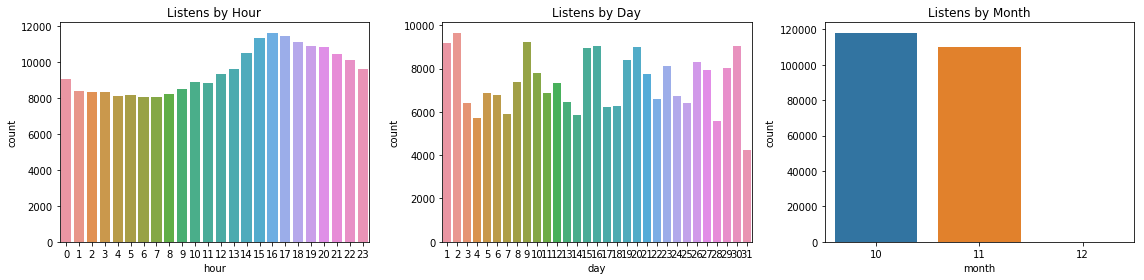

In [28]:
plt.figure(figsize=(16,4))

plt.subplot(131)
sns.countplot(x='hour',data=df_pd)
plt.title('Listens by Hour')

plt.subplot(132)
sns.countplot(x='day',data=df_pd)
plt.title('Listens by Day')

plt.subplot(133)
sns.countplot(x='month',data=df_pd)
plt.title('Listens by Month')

plt.tight_layout()

Looks like we only have data from 2018 from the smaller dataset.

*Note to self: Revisit comments for the 12GB dataset*

### Looking at User Behavior

Now taking a look at average listens per user using the `NextSong` page. Practicing using Spark SQL.

In [29]:
df.createOrReplaceTempView('user_data')

In [30]:
query = '''
SELECT userId, COUNT(userId) AS count
FROM user_data
WHERE page = 'NextSong'
GROUP BY userID
ORDER BY count DESC
'''
spark.sql(query).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 8002|
|    92| 5945|
|   140| 5664|
|300011| 4619|
|   124| 4079|
|300021| 3816|
|300017| 3632|
|    85| 3616|
|    42| 3573|
|     6| 3159|
|    29| 3028|
|200023| 2955|
|    54| 2841|
|   100| 2682|
|     9| 2676|
|    91| 2580|
|   126| 2577|
|300015| 2524|
|    98| 2401|
|    74| 2400|
+------+-----+
only showing top 20 rows



#### Making a days with consecutive listens feature

In [31]:
listen_flag = udf(lambda x: 1 if x=='NextSong' else 0, IntegerType())
df = df.withColumn('listen_flag',listen_flag('page'))
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018, date=datetime.date(2018, 10, 1), listen_flag=1)]

Let's create a second table that will contain dates and cumulative listen counts that I will later join

In [32]:
df_listen_day = df.select(['userId','date','listen_flag']) \
                .groupBy(['userId','date']) \
                .agg(Fmax('listen_flag')).alias('listen_flag').sort(['userId','date'])
df_listen_day.show(10)

+------+----------+----------------+
|userId|      date|max(listen_flag)|
+------+----------+----------------+
|    10|2018-10-08|               1|
|    10|2018-10-18|               1|
|    10|2018-10-19|               1|
|    10|2018-10-29|               1|
|    10|2018-11-03|               1|
|    10|2018-11-15|               1|
|    10|2018-11-16|               1|
|    10|2018-11-19|               1|
|   100|2018-10-02|               1|
|   100|2018-10-03|               1|
+------+----------+----------------+
only showing top 10 rows



In [33]:
window = Window \
        .partitionBy('userId') \
        .orderBy(col('date'))

df_listen_day = df_listen_day \
                    .withColumn('prev_day',lag(col('date')) \
                    .over(window))
df_listen_day.show()

+------+----------+----------------+----------+
|userId|      date|max(listen_flag)|  prev_day|
+------+----------+----------------+----------+
|100010|2018-10-08|               1|      null|
|100010|2018-10-15|               1|2018-10-08|
|100010|2018-10-16|               1|2018-10-15|
|100010|2018-10-20|               1|2018-10-16|
|100010|2018-11-05|               1|2018-10-20|
|100010|2018-11-09|               1|2018-11-05|
|100010|2018-11-21|               1|2018-11-09|
|200002|2018-10-01|               1|      null|
|200002|2018-10-02|               1|2018-10-01|
|200002|2018-10-16|               1|2018-10-02|
|200002|2018-10-18|               1|2018-10-16|
|200002|2018-10-22|               1|2018-10-18|
|200002|2018-10-23|               1|2018-10-22|
|200002|2018-11-15|               1|2018-10-23|
|   125|2018-10-12|               1|      null|
|   124|2018-10-01|               1|      null|
|   124|2018-10-02|               1|2018-10-01|
|   124|2018-10-03|               1|2018

In [34]:
def compare_date_cols(x,y):
    if x != y:
        return 0
    else:
        return 1
    
date_group = udf(compare_date_cols, IntegerType())

windowval = (Window.partitionBy('userId').orderBy('date')
             .rangeBetween(Window.unboundedPreceding, 0))

df_listen_day = df_listen_day \
                        .withColumn( \
                            'date_group',
                             date_group(col('date'), date_add(col('prev_day'),1)) \
                            ) \
                        .withColumn( \
                             'days_consec_listen',
                             Fsum('date_group').over(windowval)) \
                        .select(['userId','date','days_consec_listen'])

In [35]:
df_listen_day.show()

+------+----------+------------------+
|userId|      date|days_consec_listen|
+------+----------+------------------+
|100010|2018-10-08|                 0|
|100010|2018-10-15|                 0|
|100010|2018-10-16|                 1|
|100010|2018-10-20|                 1|
|100010|2018-11-05|                 1|
|100010|2018-11-09|                 1|
|100010|2018-11-21|                 1|
|200002|2018-10-01|                 0|
|200002|2018-10-02|                 1|
|200002|2018-10-16|                 1|
|200002|2018-10-18|                 1|
|200002|2018-10-22|                 1|
|200002|2018-10-23|                 2|
|200002|2018-11-15|                 2|
|   125|2018-10-12|                 0|
|   124|2018-10-01|                 0|
|   124|2018-10-02|                 1|
|   124|2018-10-03|                 2|
|   124|2018-10-04|                 3|
|   124|2018-10-05|                 4|
+------+----------+------------------+
only showing top 20 rows



In [36]:
df = df.join(other=df_listen_day,on=['userId','date'],how='left')
shape_ps_df(df)

DF Shape: (278154,26)


In [37]:
df.where(col('page')=='NextSong') \
    .select(['userId','date','days_consec_listen']) \
    .sort(['userId','date']) \
    .dropDuplicates(['userId','date']) \
    .show()

+------+----------+------------------+
|userId|      date|days_consec_listen|
+------+----------+------------------+
|    10|2018-10-08|                 0|
|    10|2018-10-18|                 0|
|    10|2018-10-19|                 1|
|    10|2018-10-29|                 1|
|    10|2018-11-03|                 1|
|    10|2018-11-15|                 1|
|    10|2018-11-16|                 2|
|    10|2018-11-19|                 2|
|   100|2018-10-02|                 0|
|   100|2018-10-03|                 1|
|   100|2018-10-04|                 2|
|   100|2018-10-07|                 2|
|   100|2018-10-09|                 2|
|   100|2018-10-10|                 3|
|   100|2018-10-17|                 3|
|   100|2018-10-19|                 3|
|   100|2018-10-23|                 3|
|   100|2018-10-24|                 4|
|   100|2018-10-25|                 5|
|   100|2018-10-26|                 6|
+------+----------+------------------+
only showing top 20 rows



Making a days since last listen feature

In [38]:
df_listen_day = df.select(['userId','date','listen_flag']) \
                .groupBy(['userId','date']) \
                .agg(Fmax('listen_flag')).alias('listen_flag').sort(['userId','date'])

In [39]:
df_listen_day.show()

+------+----------+----------------+
|userId|      date|max(listen_flag)|
+------+----------+----------------+
|    10|2018-10-08|               1|
|    10|2018-10-18|               1|
|    10|2018-10-19|               1|
|    10|2018-10-29|               1|
|    10|2018-11-03|               1|
|    10|2018-11-15|               1|
|    10|2018-11-16|               1|
|    10|2018-11-19|               1|
|   100|2018-10-02|               1|
|   100|2018-10-03|               1|
|   100|2018-10-04|               1|
|   100|2018-10-07|               1|
|   100|2018-10-09|               1|
|   100|2018-10-10|               1|
|   100|2018-10-17|               1|
|   100|2018-10-19|               1|
|   100|2018-10-23|               1|
|   100|2018-10-24|               1|
|   100|2018-10-25|               1|
|   100|2018-10-26|               1|
+------+----------+----------------+
only showing top 20 rows



In [40]:
windowval = Window.partitionBy('userId').orderBy('date')

df_last_listen = df_listen_day.withColumn('days_since_last_listen',
                        datediff(col('date'),lag(col('date')).over(windowval))) \
                        .fillna(0,subset=['days_since_last_listen']) \
                        .select(['userId','date','days_since_last_listen'])

In [41]:
df_last_listen.show()

+------+----------+----------------------+
|userId|      date|days_since_last_listen|
+------+----------+----------------------+
|100010|2018-10-08|                     0|
|100010|2018-10-15|                     7|
|100010|2018-10-16|                     1|
|100010|2018-10-20|                     4|
|100010|2018-11-05|                    16|
|100010|2018-11-09|                     4|
|100010|2018-11-21|                    12|
|200002|2018-10-01|                     0|
|200002|2018-10-02|                     1|
|200002|2018-10-16|                    14|
|200002|2018-10-18|                     2|
|200002|2018-10-22|                     4|
|200002|2018-10-23|                     1|
|200002|2018-11-15|                    23|
|   125|2018-10-12|                     0|
|   124|2018-10-01|                     0|
|   124|2018-10-02|                     1|
|   124|2018-10-03|                     1|
|   124|2018-10-04|                     1|
|   124|2018-10-05|                     1|
+------+---

In [42]:
df = df.join(df_last_listen,on=['userId','date'],how='left')

In [43]:
df.take(1)

[Row(userId='110', date=datetime.date(2018, 11, 5), artist=None, auth='Logged In', firstName='William', gender='M', itemInSession=0, lastName='Thompson', length=None, level='free', location='Chicago-Naperville-Elgin, IL-IN-WI', method='GET', page='Home', registration=1537665002000, sessionId=1512, song=None, status=200, ts=1541379932000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', state='WI', hour=1, day=5, month=11, year=2018, listen_flag=0, days_consec_listen=0, days_since_last_listen=4)]

#### Running Listens By Month

In [44]:
windowval = Window.partitionBy('userId').orderBy(date_trunc('month',col('date')))

df_running_listens = df \
                    .where(col('listen_flag')==1) \
                    .withColumn('running_listens_mon',row_number().over(windowval)) \
                    .select(['userId','ts','running_listens_mon','date'])

In [45]:
df = df.join(df_running_listens.select(['userId','ts','running_listens_mon']),
                                       on=['userId','ts'],how='left')

In [46]:
df.take(1)

[Row(userId='10', ts=1539837270000, date=datetime.date(2018, 10, 18), artist='Samy Deluxe', auth='Logged In', firstName='Brycen', gender='M', itemInSession=14, lastName='Bradley', length=212.47955, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=595, song='Verdammtnochma', status=200, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', state='MS', hour=4, day=18, month=10, year=2018, listen_flag=1, days_consec_listen=0, days_since_last_listen=10, running_listens_mon=90)]

In [47]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- listen_flag: integer (nullable = true)
 |-- days_consec_listen: long (nullable = t

In [48]:
df.select(['userId','date','page','running_listens_mon']).sort(['userId','ts']).show()

+------+----------+----------+-------------------+
|userId|      date|      page|running_listens_mon|
+------+----------+----------+-------------------+
|    10|2018-10-08|  NextSong|                 22|
|    10|2018-10-08|  NextSong|                 23|
|    10|2018-10-08|  NextSong|                 24|
|    10|2018-10-08|  NextSong|                 25|
|    10|2018-10-08|  NextSong|                 26|
|    10|2018-10-08|  NextSong|                 27|
|    10|2018-10-08|  NextSong|                 28|
|    10|2018-10-08| Thumbs Up|               null|
|    10|2018-10-08|  NextSong|                 29|
|    10|2018-10-08|  NextSong|                 30|
|    10|2018-10-08|  NextSong|                 31|
|    10|2018-10-08|Add Friend|               null|
|    10|2018-10-08|Add Friend|               null|
|    10|2018-10-08|  NextSong|                 32|
|    10|2018-10-08|  NextSong|                 33|
|    10|2018-10-08| Thumbs Up|               null|
|    10|2018-10-08|  NextSong| 

Let's see how many nulls we have...

In [49]:
df.where(col('running_listens_mon').isNull()).count()

49400

In [50]:
df = df.sort(['userId','ts'])

In [51]:
windowval = Window.partitionBy(col('userId')).orderBy(col('ts'))

running_listens_lag = lag(df['running_listens_mon']).over(windowval)

In [52]:
df = df.withColumn('running_listens_mon_fill', 
              when(col('running_listens_mon').isNull(),running_listens_lag) \
                .otherwise(col('running_listens_mon')))

In [53]:
df.select(['userId','ts','page','running_listens_mon','running_listens_mon_fill']) \
    .sort(['userId','ts']) \
    .show()

+------+-------------+----------+-------------------+------------------------+
|userId|           ts|      page|running_listens_mon|running_listens_mon_fill|
+------+-------------+----------+-------------------+------------------------+
|    10|1538965220000|  NextSong|                 22|                      22|
|    10|1538965485000|  NextSong|                 23|                      23|
|    10|1538965685000|  NextSong|                 24|                      24|
|    10|1538965893000|  NextSong|                 25|                      25|
|    10|1538966419000|  NextSong|                 26|                      26|
|    10|1538966691000|  NextSong|                 27|                      27|
|    10|1538966898000|  NextSong|                 28|                      28|
|    10|1538966899000| Thumbs Up|               null|                      28|
|    10|1538967004000|  NextSong|                 29|                      29|
|    10|1538967243000|  NextSong|                 30

In [54]:
df.where(col('running_listens_mon_fill').isNull()).count()

10389

Still have null values that have to be filled. Re-running the lag as a loop.

In [55]:
n_null = df.where(col('running_listens_mon_fill').isNull()).count()
n_null

10389

In [56]:
i = 0
while n_null > 0:
    # Re-creating a lag column based on the filled values
    running_listens_lag = lag(df['running_listens_mon_fill']).over(windowval)
    
    # Replacing 'running_listens_mon_fill' with new filled values
    df = df.withColumn('running_listens_mon_fill', 
                  when(col('running_listens_mon_fill').isNull(),running_listens_lag) \
                    .otherwise(col('running_listens_mon_fill')))

    n_null = df.where(col('running_listens_mon_fill').isNull()).count()
    i += 1
    print(f'Loop {i}\nNull values left: {n_null}')
    
    if i >10:
        print('Breaking loop to save computation time. Filling remaining null values with average.')
        filled_average = df.agg(Favg(col('running_listens_mon_fill'))).collect()[0][0]
        print(f'Average of the column: {round(filled_average)}')
        df = df.fillna(round(filled_average),subset=['running_listens_mon_fill'])

print(f'Done.\nNumber of null values remaining: {n_null}')

Loop 1
Null values left: 2979
Loop 2
Null values left: 1023
Loop 3
Null values left: 447
Loop 4
Null values left: 253
Loop 5
Null values left: 183
Loop 6
Null values left: 156
Loop 7
Null values left: 142
Loop 8
Null values left: 136
Loop 9
Null values left: 134
Loop 10
Null values left: 132
Loop 11
Null values left: 131
Breaking loop to save computation time. Filling remaining null values with average.
Average of the column: 1099
Loop 12
Null values left: 0
Breaking loop to save computation time. Filling remaining null values with average.
Average of the column: 1099
Done.
Number of null values remaining: 0


#### NOTE TO SELF: Consider Adding these as features

#### Calculating User Average Listens Each Month

In [ ]:
# df_running_listens \
#         .groupBy(col('userId'),date_trunc('month',col('date'))) \ # Grouping by each user, then month
#         .Fmax(col('running_listens_mon')) \ # Getting max user listens
#         .show()

Making a song repeat feature

Making a thumbs-up in past month feature

Making a add-to-playlist in past month feature

Making a thumbs-down in past month feature

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [57]:
def label_churn(x):
    if x=='Cancellation Confirmation':
        return 1
    elif x=='Downgrade':
        return 1
    else:
        return 0
udf_label_churn = udf(label_churn, IntegerType())

df = df.withColumn('Churn',udf_label_churn(col('page')))

In [58]:
df.take(1)

[Row(userId='100010', ts=1539003534000, date=datetime.date(2018, 10, 8), artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', state='CT', hour=12, day=8, month=10, year=2018, listen_flag=1, days_consec_listen=0, days_since_last_listen=0, running_listens_mon=1, running_listens_mon_fill=1, Churn=0)]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [59]:
# How many labels?
df.groupBy('Churn').agg(count('userId').alias('count')).show()

+-----+------+
|Churn| count|
+-----+------+
|    1|  2107|
|    0|276047|
+-----+------+



In [60]:
# No. unique churned users
df.where(col('Churn')==1).select('userId').dropDuplicates().count()

171

Looking at average of the running listens per month feature

In [61]:
df.groupBy('Churn').agg(Favg(col('running_listens_mon'))).show()

+-----+------------------------+
|Churn|avg(running_listens_mon)|
+-----+------------------------+
|    1|      1015.5918367346939|
|    0|      1106.3705909359219|
+-----+------------------------+



In [62]:
df.groupBy('Churn').agg(Favg(col('running_listens_mon_fill'))).show()

+-----+-----------------------------+
|Churn|avg(running_listens_mon_fill)|
+-----+-----------------------------+
|    1|           1159.6459420977694|
|    0|           1098.1006422819303|
+-----+-----------------------------+



Taking a look at Average Listens per user and splitting by whether they churned

In [68]:
df_avg_listens_user = df.groupBy('userId') \
            .agg(Fmax(col('running_listens_mon_fill')))
df_avg_listens_user.show(5)

+------+-----------------------------+
|userId|max(running_listens_mon_fill)|
+------+-----------------------------+
|100010|                          275|
|200002|                          387|
|   125|                            8|
|   124|                         4079|
|    51|                         2111|
+------+-----------------------------+
only showing top 5 rows



In [69]:
df_churned_users = df.where(col('Churn')==1).select(['userId','Churn']).dropDuplicates(['userId'])
df_churned_users.show(5)

+------+-----+
|userId|Churn|
+------+-----+
|200002|    1|
|   125|    1|
|   124|    1|
|    51|    1|
|    15|    1|
+------+-----+
only showing top 5 rows



In [77]:
df_churned_users.count()

171

In [74]:
df_avg_listens_user_churn = df_avg_listens_user.join(df_churned_users,['userId'],'left').fillna(0,['Churn'])

In [75]:
df_avg_listens_user_churn.show(10)

+------+-----------------------------+-----+
|userId|max(running_listens_mon_fill)|Churn|
+------+-----------------------------+-----+
|100010|                          275|    0|
|200002|                          387|    1|
|   125|                            8|    1|
|   124|                         4079|    1|
|    51|                         2111|    1|
|     7|                          150|    0|
|    15|                         1914|    1|
|    54|                         2841|    1|
|   155|                         1099|    1|
|100014|                          257|    1|
+------+-----------------------------+-----+
only showing top 10 rows



In [76]:
df_avg_listens_user_churn \
    .groupBy('Churn') \
    .agg(Favg(col('max(running_listens_mon_fill)')) \
            .alias('Average Listens')) \
    .show()

+-----+------------------+
|Churn|   Average Listens|
+-----+------------------+
|    1|1422.6783625730993|
|    0| 727.6851851851852|
+-----+------------------+



Interesting. I would've guessed that the churned users would have less average listens than users who didn't churn.

The results would probably look a lot different if this was applied to the entire dataset. 171/225 unique users in this smaller dataset churned.

---

Taking a look at days since last listen for churned users

In [81]:
df_last_listen_churn = df.where(col('Churn')==1) \
                        .dropDuplicates(['userId']) \
                        .select(['userId','page','days_since_last_listen'])

In [83]:
df_last_listen_churn.show()

+------+--------------------+----------------------+
|userId|                page|days_since_last_listen|
+------+--------------------+----------------------+
|200002|           Downgrade|                     2|
|   125|Cancellation Conf...|                     0|
|   124|           Downgrade|                     0|
|    51|           Downgrade|                     0|
|    15|           Downgrade|                     0|
|    54|           Downgrade|                     0|
|   155|           Downgrade|                     7|
|100014|           Downgrade|                     4|
|   132|           Downgrade|                     2|
|   101|           Downgrade|                     1|
|    11|           Downgrade|                     6|
|   138|           Downgrade|                     2|
|300017|           Downgrade|                     1|
|100021|Cancellation Conf...|                    22|
|    29|           Downgrade|                     1|
|    69|           Downgrade|                 

In [86]:
df_last_listen_churn.select(Favg(col('days_since_last_listen')).alias('Avg Days Since Last Listen')).show()

+--------------------------+
|Avg Days Since Last Listen|
+--------------------------+
|        3.1871345029239766|
+--------------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Prepping Data For Model

In [88]:
gender_indexer = StringIndexer(inputCol='gender',outputCol='gender_indexed')
fitted_gender_indexer = gender_indexer.fit(df)
df = fitted_gender_indexer.transform(df)

In [89]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- listen_flag: integer (nullable = true)
 |-- days_consec_listen: long (nullable = t

In [90]:
assembler = VectorAssembler(inputCols=['hour','day','month','days_consec_listen',
                                       'days_since_last_listen','running_listens_mon_fill','gender_indexed'],
                            outputCol='features')
df = assembler.transform(df)

In [93]:
df_model = df.select(col('features'),col('Churn').alias('label'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

--- 
Example workflow for pipeline and cross validation fit

```python
regexTokenizer = RegexTokenizer(inputCol="Body", outputCol="words", pattern="\\W")
cv = CountVectorizer(inputCol="words", outputCol="TF", vocabSize=1000)
idf = IDF(inputCol="TF", outputCol="features")
indexer = StringIndexer(inputCol="oneTag", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[regexTokenizer, cv, idf, indexer, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(cv.vocabSize,[1000, 5000]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_q1 = crossval.fit(rest)
```

---
Example scaler

```python
scaler_q2 = StandardScaler(inputCol="DescVec", outputCol="DescVecStandardScaler4", withMean=False, withStd=False)
scalerModel_q2 = scaler_q2.fit(df)
df = scalerModel_q2.transform(df)
```

In [91]:
# Maybe no need for Scaler?
# scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)

In [94]:
lr = LogisticRegression(maxIter=30)
gbt = GBTClassifier()
rf = RandomForestClassifier()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.